In [1]:
import pickle
import boris_extraction as boris
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))


def random_event_generator(start, stop, len_event, no_events):
    total_duration = stop - start
    possible_events = np.arange(int(total_duration / len_event))
    pot_events = np.random.choice(possible_events, size = (no_events), replace = False)
    pot_events = np.sort(pot_events)
    events = []
    for i in pot_events: 
        event_start = (start + (len_event * i)) * 1000
        event_stop = (event_start + (len_event * 1000))
        events.append(np.array([event_start, event_stop]))
    return(np.array(events))

def p2_create_random_array(times, order, len_event, no_events, media_duration):
    media_duration = media_duration/1000
    acquisition_array = random_event_generator(0, times[0], len_event, no_events)
    exposure1_array = random_event_generator(times[3], times[4], len_event, no_events)
    exposure2_array = random_event_generator(times[5], times[6], len_event, no_events)
    exposure3_array = random_event_generator(times[7], media_duration, len_event, no_events)
    order_arrays = [exposure1_array, exposure2_array, exposure3_array]
    for i in range(len(order)):
        if order[i] == 'familiar':
            recall_array = order_arrays[i]
        if order[i] == 'cagemate':
            cagemate_array = order_arrays[i]
        if order[i] == 'novel':
            novel_array = order_arrays[i]
    event_dict = {'acquisition': acquisition_array, 'recall': recall_array, 'cagemate':cagemate_array, 'novel': novel_array, 
                'exposure 0': acquisition_array, 'exposure 1':exposure1_array, 'exposure 2': exposure2_array, 'exposure 3': exposure3_array}

    return event_dict

def p2_create_array(boris_df, times, order, min_iti, min_bout):
    familiarization_df = boris_df[(boris_df['Start (s)'] < times[0])]
    if order[0] == 'familiar':
        recall_df = boris_df[(boris_df['Start (s)'] > times[3]) & (boris_df['Start (s)'] < times[4])]
        exposure1_df = recall_df
    if order[0] == 'cagemate':
        cagemate_df = boris_df[(boris_df['Start (s)'] > times[3]) & (boris_df['Start (s)'] < times[4])]
        exposure1_df = cagemate_df
    if order[0] == 'novel':
        novel_df = boris_df[(boris_df['Start (s)'] > times[3]) & (boris_df['Start (s)'] < times[4])]
        exposure1_df = novel_df
    if order[1] == 'familiar':
        recall_df = boris_df[(boris_df['Start (s)'] > times[5]) & (boris_df['Start (s)'] < times[6])]
        exposure2_df = recall_df 
    if order[1] == 'cagemate':
        cagemate_df = boris_df[(boris_df['Start (s)'] > times[5]) & (boris_df['Start (s)'] < times[6])]
        exposure2_df = cagemate_df 
    if order[1] == 'novel':
        novel_df = boris_df[(boris_df['Start (s)'] > times[5]) & (boris_df['Start (s)'] < times[6])]
        exposure2_df = novel_df
    if order[2] == 'familiar':
        recall_df = boris_df[boris_df['Start (s)'] > times[7]]
        exposure3_df = recall_df 
    if order[2] == 'novel':
        novel_df = boris_df[boris_df['Start (s)'] > times[7]]
        exposure3_df = novel_df
    if order[2] == 'cagemate':
        cagemate_df = boris_df[boris_df['Start (s)'] > times[7]]
        exposure3_df = cagemate_df 

    acquisition_array = boris.get_behavior_bouts(familiarization_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    recall_array = boris.get_behavior_bouts(recall_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    cagemate_array = boris.get_behavior_bouts(cagemate_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    novel_array = boris.get_behavior_bouts(novel_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    exposure1_array = boris.get_behavior_bouts(exposure1_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    exposure2_array = boris.get_behavior_bouts(exposure2_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    exposure3_array = boris.get_behavior_bouts(exposure3_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    event_dict = {'acquisition': acquisition_array, 'recall': recall_array, 'cagemate':cagemate_array, 'novel': novel_array, 
                      'exposure 0': acquisition_array, 'exposure 1':exposure1_array, 'exposure 2': exposure2_array, 'exposure 3': exposure3_array}

    return event_dict

def p2_make_assignment(recording, subject, event_dict):
    recording.event_dict = event_dict
    recording.subject = subject

def p2_camera_crash(boris_df1, boris_df2, times1, times2, order, media_duration, last_timestamp, min_iti, min_bout):
    array_1 = p2_create_array(boris_df1, times1, order, min_iti, min_bout)
    array_2 = p2_create_array(boris_df2, times2, order, min_iti, min_bout)
    diff = (last_timestamp / 20000 * 1000) - (media_duration)
    final_dict = {}
    for event, times in array_1.items():
        array_2[event] = array_2[event] + diff
        new_array = np.concatenate([array_1[event], array_2[event]])
        final_dict[event] = new_array
    return final_dict
    
def p2_camera_crash_random(times1, times2, order, media_duration2, last_timestamp, len_event, no_events):
    diff = (last_timestamp / 20000) - (media_duration2/1000)
    times1 = np.array(times1)
    times2 = np.array(times2)
    times = [0,0,0,0,0,0,0,0]
    for i in range(len(times1)):
        if i == len(times1) - 1:
            times[i] = times2[i] + diff
        else:
            if times1[i+1] != 0:
                if i == len(times1) - 2:
                    times[i] = times2[i] + diff
                else:
                    times[i] = times1[i]
            else:
                times[i] = times2[i] + diff
    event_dict = p2_create_random_array(times, order, len_event, no_events, (last_timestamp/20))
    return event_dict  


def assign_dicts(ephys_collection, dict_dict):
    """
    Assigns behavior dictionaries to recordings in an ephys collection

    Args(2):
        ephys_collection: an ephys collection class instance
        dict_dict: dict, a dictionary of behavior event dictionaries
            keys: recording names 
            values: behavior event dictionaries (keys: events, values: start stop times)
    """
    collection = ephys_collection.collection
    for recording, event_dict in dict_dict.items():
        collection[recording].event_dict = event_dict

        
def create_collection(new=False):
    if new:
        phase2_collection = spike.EphysRecordingCollection("D:\\social_ephys_pilot2_cum\\proc\\Phase 2")
        with open('phase2collection.pkl','wb') as file:
                pickle.dump(phase2_collection, file)
    else:
        try:
            with open('phase2collection.pkl', 'rb') as file:
                phase2_collection = pickle.load(file)
        except FileNotFoundError:
            phase2_collection = spike.EphysRecordingCollection("D:\\social_ephys_pilot2_cum\\proc\\Phase 2")
            with open('phase2collection.pkl','wb') as file:
                pickle.dump(phase2_collection, file)
    return phase2_collection

In [4]:
phase2_collection = create_collection()
FCN_1_1 = phase2_collection.get_by_name('20230803_101331_1_merged.rec')
CNF_1_1 = phase2_collection.get_by_name('20230817_100823_1_merged.rec')
NFC_1_1 = phase2_collection.get_by_name('20230818_115728_1_merged.rec')

NFC_1_2 = phase2_collection.get_by_name('20230804_141009_1_merged.rec')
FCN_1_2 = phase2_collection.get_by_name('20230817_113746_1_merged.rec')
CNF_1_2 = phase2_collection.get_by_name('20230803_141047_1_merged.rec')
                                        
FCN_1_4 = phase2_collection.get_by_name('20230804_121600_1_merged.rec')
NFC_1_4 = phase2_collection.get_by_name('20230803_121318_1_merged.rec')
CNF_1_4 = phase2_collection.get_by_name('20230818_133620_1_merged.rec')
FCN_1_1.subject = '1.1'
CNF_1_1.subject = '1.1'
NFC_1_1.subject = '1.1'
NFC_1_2.subject = '1.2'
FCN_1_2.subject = '1.2'
CNF_1_2.subject = '1.2'
FCN_1_4.subject = '1.4'
NFC_1_4.subject = '1.4'
CNF_1_4.subject = '1.4'

In [5]:
try:
    #ONE VIDEO
    #NEED TO DO ADD MEDIA DURAITONS FOR ALL VIDEOS REGARDLESS OF TIME CRASH 
    #20230817_100823_1.1_CNF
    CNF_1_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230817_100823_1_merged.rec\\20230817_100823_1.1_CNF.xlsx")
    times_CNF_1_1 = [630, 633, 1226, 1228, 1526, 1531, 1828, 1832]
    order_CNF_1_1 = ['cagemate', 'novel', 'familiar']
    CNF_1_1_media_duration = 2131.233 * 1000
    CNF_1_1_last_timestamp = CNF_1_1.timestamps_var[-1]


    #TWO VIDEOS
    #20230803_101331_1_FCN_1
    FCN_1_1_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_101331_1_merged.rec\\20230803 101331 1.1.xlsx")
    FCN_1_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\Phase 2\\20230803_101331_1_merged.rec\\20230803 101331 1.2.xlsx")
    times_FCN_1_1_1 = [599, 603, 821, 0, 0, 0, 0, 99999999999]
    times_FCN_1_1_2 = [0, 0, 374, 377, 671, 677, 970, 976]
    order_FCN_1_1 = ['familiar', 'cagemate', 'novel']
    FCN_1_1_media_duration = 1290.567 * 1000
    FCN_1_1_last_timestamp = FCN_1_1.timestamps_var[-1]
    FCN_1_1_media_duration1 = 821.200 * 1000


    #20230818_115728_1.1_NFC
    NFC_1_1_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230818_115728_1_merged.rec\\20230818 115728 1.1.xlsx")
    NFC_1_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230818_115728_1_merged.rec\\20230818 115728 1.2.xlsx")
    times_NFC_1_1_1 = [111, 0, 0, 0, 0, 0, 0, 99999999999]
    times_NFC_1_1_2 = [527, 533, 1147, 1151, 1446, 1454, 1754, 1762]
    order_NFC_1_1 = ['novel', 'familiar', 'cagemate']
    NFC_1_1_media_duration = 2059.6 * 1000
    NFC_1_1_last_timestamp = NFC_1_1.timestamps_var[-1]
    NFC_1_1_media_duration1 = 115.667 * 1000

    #20230704_141009_1.2_NFC8
    NFC_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230804_141009_1_merged.rec\\20230804_141009_1.2_2t2bL_NFC.xlsx")
    times_NFC_1_2 = [600, 606, 1199, 1202, 1500, 1508, 1800, 1806]
    order_NFC_1_2 = ['novel', 'familiar', 'cagemate']
    NFC_1_2_media_duration  = 2106.100 * 1000
    NFC_1_2_last_timestamp = NFC_1_2.timestamps_var[-1]



    #20230817_113746_1.2_FCN
    FCN_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230817_113746_1_merged.rec\\20230817_113746_1.2_2t2bL_FCN.xlsx")
    times_FCN_1_2 = [599, 604, 1200, 1203, 1499, 1506, 1811, 1817]
    order_FCN_1_2 = ['familiar', 'cagemate', 'novel']
    FCN_1_2_media_duration = 2110.67 * 1000
    FCN_1_2_last_timestamp = FCN_1_2.timestamps_var[-1]



    #20230803_141047_1.2_CNF
    CNF_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_141047_1_merged.rec\\20230803 _ 141047 _1.2 2t2bL CNF .xlsx")
    times_CNF_1_2 = [600, 605, 1200, 1203, 1500, 1506, 1800, 1806]
    order_CNF_1_2 = ['cagemate', 'novel', 'familiar']
    CNF_1_2_media_duration = 2101.170 * 1000
    CNF_1_2_last_timestamp = CNF_1_2.timestamps_var[-1]


    #20230804_121600_1.4_FCN
    FCN_1_4_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230804_121600_1_merged.rec\\20230804_121600_1.4_3t3bL_FCN.xlsx")
    times_FCN_1_4 = [600, 607, 1203, 1206, 1499, 1505, 1799, 1807]
    order_FCN_1_4 = ['familiar', 'cagemate', 'novel']
    FCN_1_4_media_duration = 2101.00 * 1000
    FCN_1_4_last_timestamp = FCN_1_4.timestamps_var[-1]


    #20230818_133620_1.4_CNF
    CNF_1_4_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230818_133620_1_merged.rec\\20230818_133620_1.4_3t3bL_CNF.xlsx")
    times_CNF_1_4 = [599, 605, 1158, 1202, 1497, 1503, 1800, 1806]
    order_CNF_1_4 = ['cagemate', 'novel', 'familiar']
    CNF_1_4_media_duration = 2100.333 * 1000
    CNF_1_4_last_timestamp = CNF_1_4.timestamps_var[-1]

    #20230803_121318_1.4_NFC
    NFC_1_4_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_121318_1_merged.rec\\20230803 121318 1.1.xlsx")
    NFC_1_4_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_121318_1_merged.rec\\20230803 121318 1.2.xlsx")
    times_NFC_1_4_1 = [599, 604, 1021, 0, 0, 0, 0, 99999999]
    times_NFC_1_4_2 =  [0, 0, 50, 53, 347, 354, 650, 656]
    order_NFC_1_4 = ['novel', 'familiar', 'cagemate']
    NFC_1_4_media_duration = 951.633 * 1000
    NFC_1_4_last_timestamp = NFC_1_4.timestamps_var[-1]
    NFC_1_4_media_duration1 = 1021.333 * 1000
 
    len_events = 10
    no_events = 10
    random_event_dict = {}

    CNF_1_1_arrays = p2_create_random_array(times_CNF_1_1, order_CNF_1_1, len_events, no_events, CNF_1_1_media_duration)
    random_event_dict['20230817_100823_1_merged.rec'] = CNF_1_1_arrays

    FCN_1_1_arrays = p2_camera_crash_random(times_FCN_1_1_1, times_FCN_1_1_2, order_FCN_1_1, FCN_1_1_media_duration,
                                            FCN_1_1_last_timestamp, len_events, no_events)
    random_event_dict['20230803_101331_1_merged.rec'] = FCN_1_1_arrays

    NFC_1_1_arrays = p2_camera_crash_random(times_NFC_1_1_1, times_NFC_1_1_2, order_NFC_1_1, NFC_1_1_media_duration,
                                            NFC_1_1_last_timestamp, len_events, no_events)
    random_event_dict['20230818_115728_1_merged.rec'] = NFC_1_1_arrays

    NFC_1_2_arrays = p2_create_random_array(times_NFC_1_2, order_NFC_1_2, len_events, no_events, NFC_1_2_media_duration)
    random_event_dict['20230804_141009_1_merged.rec'] = NFC_1_2_arrays

    FCN_1_2_arrays = p2_create_random_array(times_FCN_1_2, order_FCN_1_2, len_events, no_events, FCN_1_2_media_duration)
    random_event_dict['20230817_113746_1_merged.rec'] = FCN_1_2_arrays

    CNF_1_2_arrays = p2_create_random_array(times_CNF_1_2, order_CNF_1_2, len_events, no_events, CNF_1_2_media_duration)
    random_event_dict['20230803_141047_1_merged.rec'] = CNF_1_2_arrays

    FCN_1_4_arrays = p2_create_random_array(times_FCN_1_4, order_FCN_1_4, len_events, no_events, FCN_1_4_media_duration)
    random_event_dict['20230804_121600_1_merged.rec'] = FCN_1_4_arrays

    CNF_1_4_arrays = p2_create_random_array(times_CNF_1_4, order_CNF_1_4, len_events, no_events, CNF_1_4_media_duration)
    random_event_dict['20230818_133620_1_merged.rec'] = CNF_1_4_arrays

    NFC_1_4_arrays = p2_camera_crash_random(times_NFC_1_4_1, times_NFC_1_4_2, order_NFC_1_4, NFC_1_4_media_duration,
                                            NFC_1_4_last_timestamp, len_events, no_events)
    random_event_dict['20230803_121318_1_merged.rec'] = NFC_1_4_arrays
except FileNotFoundError:
    print('File not found')


In [6]:
#random_event_dict = unpickle_this('random_event_dict.pkl')
#assign_dicts(phase2_collection, random_event_dict)
randomsnippet = spike.SpikeAnalysis_MultiRecording(phase2_collection, 250, 100, 0.5)

All set to analyze


In [7]:
sniff_dict = unpickle_this('event_dict_phase2.pkl')
assign_dicts(phase2_collection, sniff_dict)
iti_snippet = spike.SpikeAnalysis_MultiRecording(phase2_collection, 250, 100, 0.5)


All set to analyze


In [8]:
for recording in phase2_collection.collection.values():
    print(recording.event_dict.keys())

dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
dict_keys(['acquisition', 'recall', 'cagemate', 'novel'

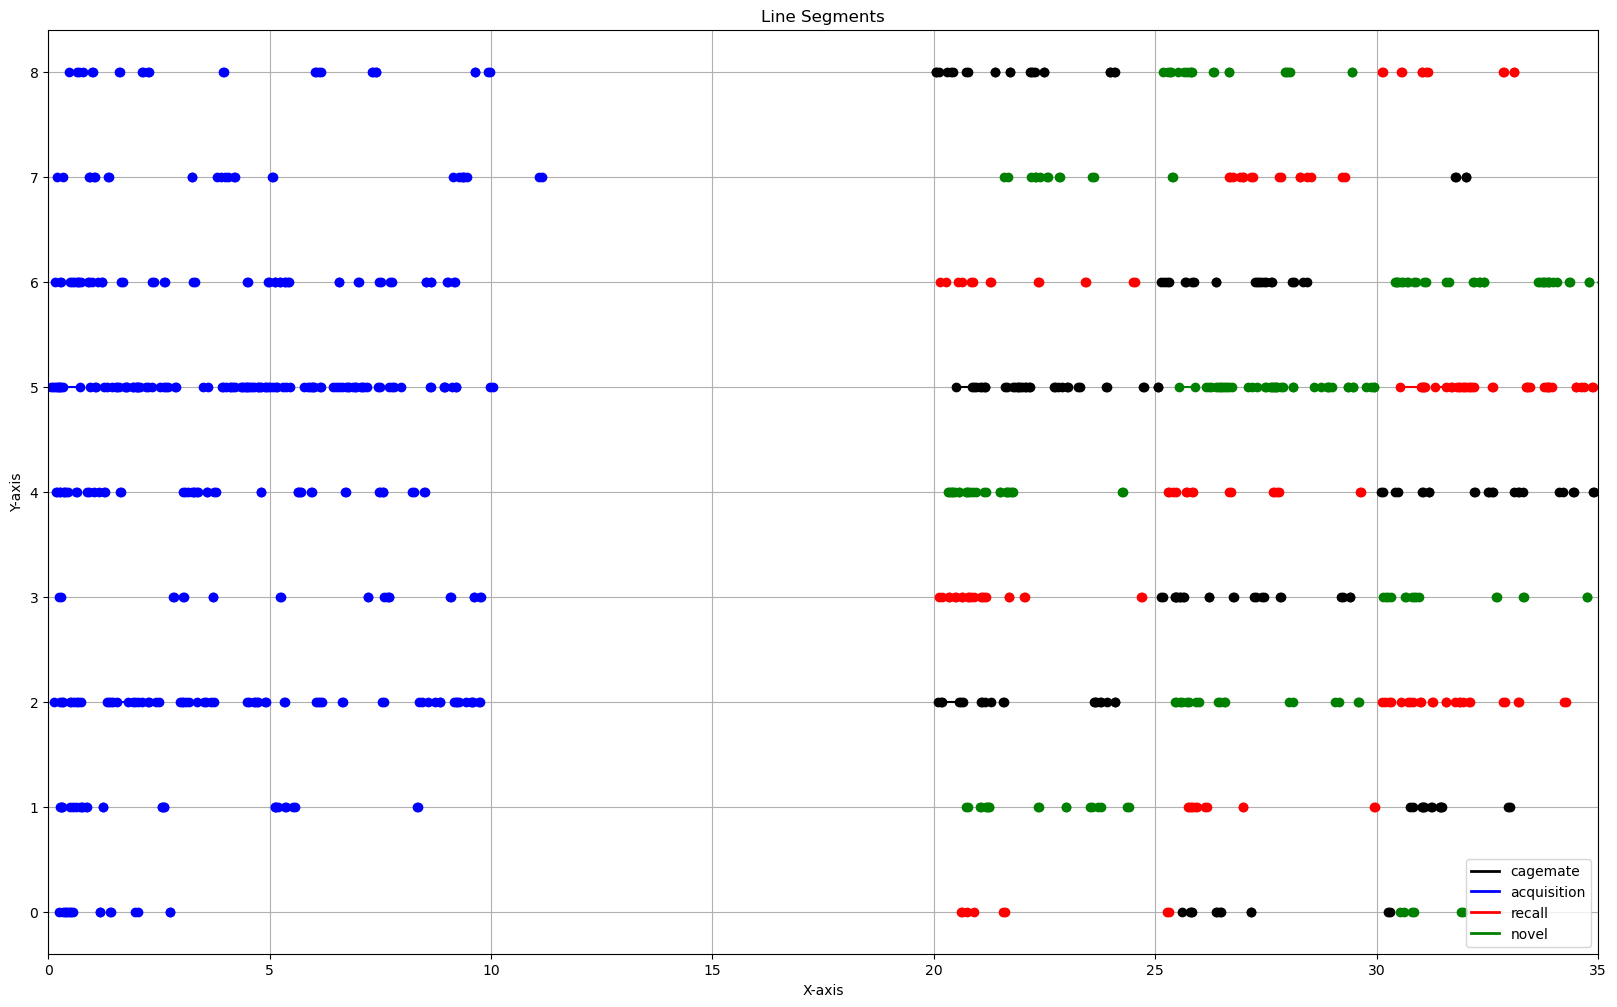

In [9]:
color_dict = {'cagemate': 'k', 'acquisition': 'b', 'recall': 'r', 'novel': 'g'}
recording_number = 0
plt.figure(figsize = (20,12))
for name, recording in phase2_collection.collection.items():
    for event, snippets in recording.event_dict.items():
        if (event =='cagemate') | (event == 'recall') | (event == 'novel') | (event == 'acquisition'):
            for i in range(len(snippets)):
                y = [recording_number,recording_number]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event])
    recording_number += 1
# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,35])
plt.show()

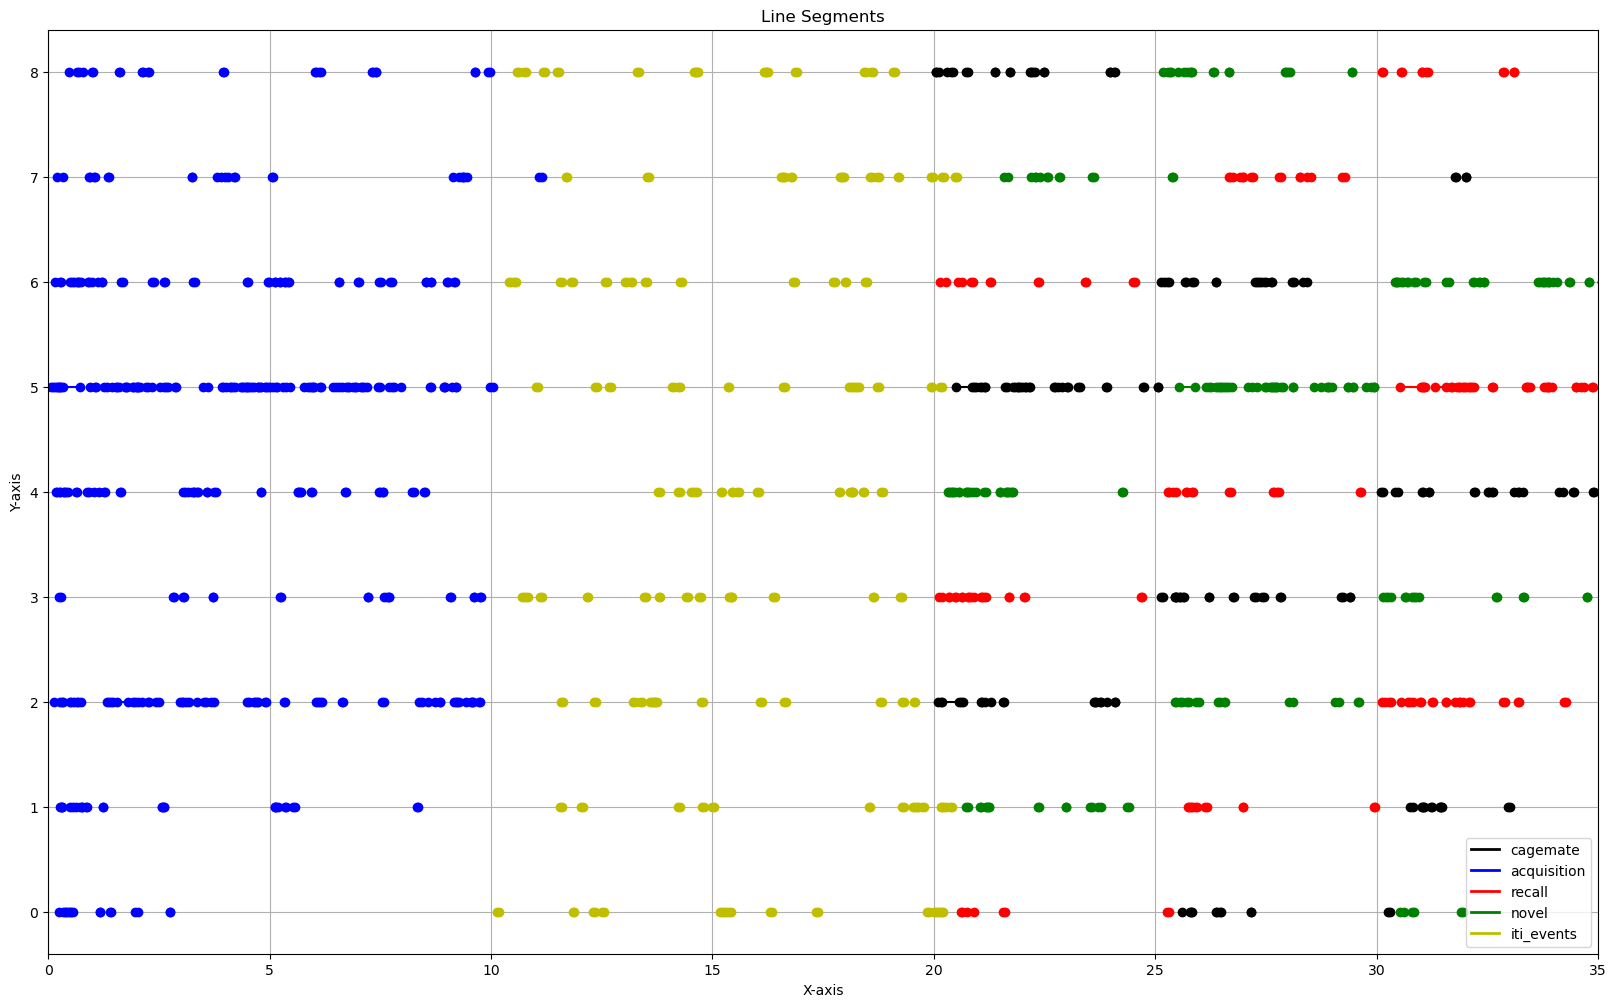

In [10]:
color_dict = {'cagemate': 'k', 'acquisition': 'b', 'recall': 'r', 'novel': 'g', 'iti_events': 'y'}
recording_number = 0
plt.figure(figsize = (20,12))
for name, recording in phase2_collection.collection.items():
    for event, snippets in recording.event_dict.items():
        if (event =='cagemate') | (event == 'recall') | (event == 'novel') | (event == 'acquisition') | (event == 'iti_events'):
            for i in range(len(snippets)):
                y = [recording_number,recording_number]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event])
    recording_number += 1
# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,35])
plt.show()

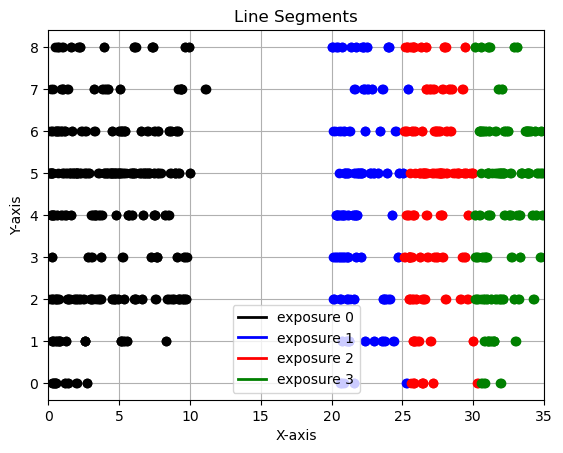

In [11]:
color_dict = {'exposure 0': 'k', 'exposure 1': 'b', 'exposure 2': 'r', 'exposure 3': 'g'}

recording_no = 0
for name, recording in phase2_collection.collection.items():
    for event, snippets in recording.event_dict.items():
        if (event =='exposure 0') | (event == 'exposure 1') | (event == 'exposure 2') | (event == 'exposure 3'):
            for i in range(len(snippets)):
                y = [recording_no, recording_no]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event])
    recording_no += 1

# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,35])
plt.show()

In [12]:
[ran_snip_auc_id, ran_snip_prob_id] = randomsnippet.trial_decoder(equalize = 10,
                                                 pre_window = 0,
                                                 post_window = 0,
                                                 num_fold=5,
                                                 num_shuffle=5,
                                                 no_PCs= 8,
                                                 events = ['novel', 'cagemate', 'recall'])

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
[ran_snip_auc, ran_snip_prob] = randomsnippet.trial_decoder(equalize = 10,
                                                 pre_window = 0,
                                                 post_window = 0,
                                                 num_fold=5,
                                                 num_shuffle=5,
                                                 no_PCs= 8,
                                                 events = ['exposure 1', 'exposure 2', 'exposure 3'])